In [8]:
# all of the necessary imports
import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure

from skimage.io import imread_collection, concatenate_images
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA

import sklearn.metrics as metrics

dataset_path = "face-expression-recognition-dataset/images/"
folders = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Histogram of Oriented Gradients (HOG)

(512, 512, 3)


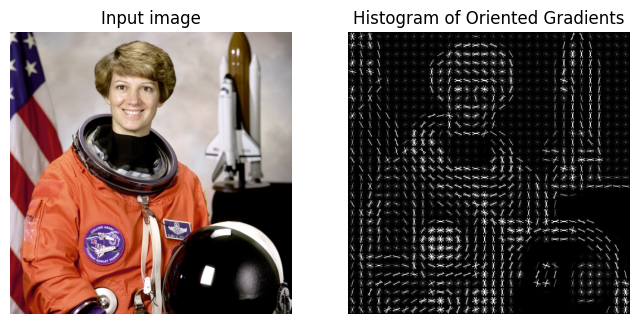

In [18]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure


image = data.astronaut()

print(image.shape)

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

(48, 48)


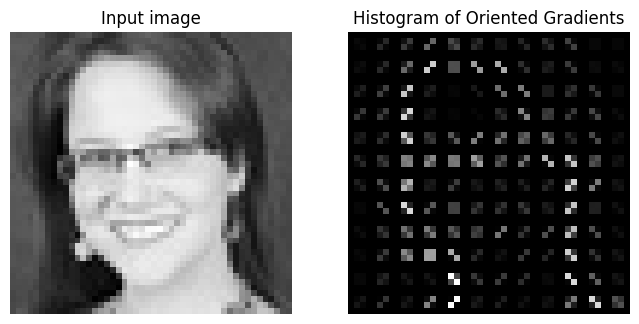

In [29]:
from skimage.feature import hog 
from skimage import io, exposure

import matplotlib.pyplot as plt

train = 'face-expression-recognition-dataset/images/train'

img_path = train + '/happy/7.jpg'

image = io.imread(img_path)

print(image.shape)

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 100))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

It looks like the images from the dataset are too small to really use HOG. EVen after tuning the parameters, it is very hard to notice where the mouth is let alone the orientation of the mouth. This is due to the fact that the outline of the face has a much much larger gradient difference than the mouth does.

In [44]:
# import images


def load_images(path):
    data = np.array([])
    labels = np.array([])

    for i, label in enumerate(folders):
        directory = path + label + '/*.jpg'
        print('Adding images from directory: ' + directory)

        ic = imread_collection(directory)
        imgs = concatenate_images(ic)

        imgs = imgs.reshape(len(imgs), -1)

        data = np.concatenate((data,imgs), axis=0) if (data.size != 0) else imgs
        labels = np.append(labels, np.array([i] * len(imgs)))

        print('Number of images in directory: ' + str(len(imgs)))

    return data, labels

train_x, train_y = load_images(dataset_path + 'train/')
test_x, test_y = load_images(dataset_path + 'validation/')

np.save("face-expression-recognition-dataset/train_x", train_x)
np.save("face-expression-recognition-dataset/train_y", train_y)
np.save("face-expression-recognition-dataset/test_x", test_x)
np.save("face-expression-recognition-dataset/test_y", test_y)



Adding images from directory: face-expression-recognition-dataset/images/train/angry/*.jpg
Number of images in directory: 3993
Adding images from directory: face-expression-recognition-dataset/images/train/disgust/*.jpg
Number of images in directory: 436
Adding images from directory: face-expression-recognition-dataset/images/train/fear/*.jpg
Number of images in directory: 4103
Adding images from directory: face-expression-recognition-dataset/images/train/happy/*.jpg
Number of images in directory: 7164
Adding images from directory: face-expression-recognition-dataset/images/train/neutral/*.jpg
Number of images in directory: 4982
Adding images from directory: face-expression-recognition-dataset/images/train/sad/*.jpg
Number of images in directory: 4938
Adding images from directory: face-expression-recognition-dataset/images/train/surprise/*.jpg
Number of images in directory: 3205
Adding images from directory: face-expression-recognition-dataset/images/validation/angry/*.jpg
Number of im

# Using PCA with Multinomial Logistic Regression

Using logistic regression on the raw data failed to converge to a solution. So instead, had to use PCA to take just the first couple best features before then running logistic regression.

In [12]:
train_x = np.load("face-expression-recognition-dataset/train_x.npy")
train_y = np.load("face-expression-recognition-dataset/train_y.npy")
test_x = np.load("face-expression-recognition-dataset/test_x.npy")
test_y = np.load("face-expression-recognition-dataset/test_y.npy")

pca = PCA(n_components=10)

train_x_pca = pca.fit_transform(train_x)

print(f'Explained Variance Ratio: {pca.explained_variance_ratio_}')
print(f'Total Explained Variance: {sum(pca.explained_variance_ratio_)}')

log_reg = LogisticRegression(max_iter=10000, verbose=1, n_jobs=-1)
log_reg.fit(train_x_pca, train_y)




Explained Variance Ratio: [0.28883101 0.09765254 0.09433207 0.0550939  0.03070064 0.02566376
 0.02143845 0.01977265 0.01776848 0.01505705]
Total Explained Variance: 0.6663105508562824


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           77     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94591D+00    |proj g|=  8.88765D+01


 This problem is unconstrained.



At iterate   50    f=  1.77747D+00    |proj g|=  2.14982D-01

At iterate  100    f=  1.77707D+00    |proj g|=  1.90749D-01

At iterate  150    f=  1.77274D+00    |proj g|=  4.80116D+00

At iterate  200    f=  1.76152D+00    |proj g|=  2.87001D-01

At iterate  250    f=  1.76118D+00    |proj g|=  1.33105D+00

At iterate  300    f=  1.76065D+00    |proj g|=  3.20997D-01

At iterate  350    f=  1.76059D+00    |proj g|=  1.68109D-01

At iterate  400    f=  1.76058D+00    |proj g|=  1.58891D-01

At iterate  450    f=  1.76050D+00    |proj g|=  1.54606D-01

At iterate  500    f=  1.76050D+00    |proj g|=  5.44897D-02

At iterate  550    f=  1.76046D+00    |proj g|=  1.36265D-01

At iterate  600    f=  1.76045D+00    |proj g|=  4.82033D-02

At iterate  650    f=  1.76044D+00    |proj g|=  2.89774D-02

At iterate  700    f=  1.76043D+00    |proj g|=  4.10772D-02

At iterate  750    f=  1.76043D+00    |proj g|=  9.78399D-02

At iterate  800    f=  1.76034D+00    |proj g|=  4.31926D-01

At iter

/home/andrew/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=10000, n_jobs=-1, verbose=1)

Training Accuracy:  0.27445265604940844
Testing Accuracy:  0.2629493348429097
Testing Precision:  0.1880962119545255
Testing Recall:  0.17857835013413167
Testing F1:  0.1521894843233517


/home/andrew/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


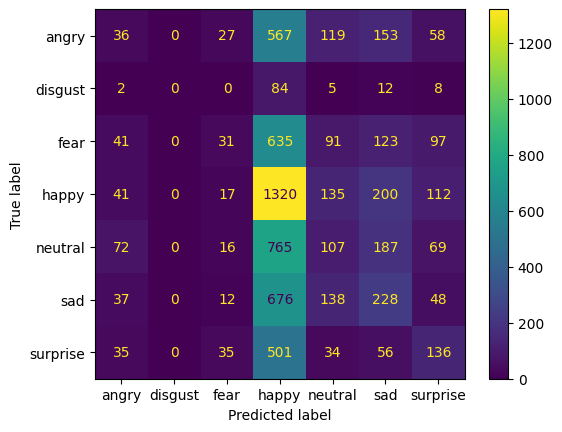

In [13]:
train_acc = log_reg.score(train_x_pca, train_y)
print("Training Accuracy: ", train_acc)

test_x_pca = pca.fit_transform(test_x)
test_y_pred = log_reg.predict(test_x_pca)

test_acc = metrics.accuracy_score(test_y, test_y_pred)
test_prec = metrics.precision_score(test_y, test_y_pred, average='macro')
test_rec = metrics.recall_score(test_y, test_y_pred, average='macro')
test_f1 = metrics.f1_score(test_y, test_y_pred, average='macro')
test_confusion = metrics.confusion_matrix(test_y, test_y_pred)
print("Testing Accuracy: ", test_acc)
print("Testing Precision: ", test_prec)
print("Testing Recall: ", test_rec)
print("Testing F1: ", test_f1)
# print("Testing Confusion Matrix: ", test_confusion)
disp = metrics.ConfusionMatrixDisplay(test_confusion, display_labels=folders)
disp.plot()

# Using HOG with Multinomial Logistic Regression

In [38]:
train_x = np.load("face-expression-recognition-dataset/train_x.npy")
train_y = np.load("face-expression-recognition-dataset/train_y.npy")
test_x = np.load("face-expression-recognition-dataset/test_x.npy")
test_y = np.load("face-expression-recognition-dataset/test_y.npy")


def get_hog(images):
    train_x_hog = []

    for i, x in enumerate(images):
        if (i % 100 == 0): 
            print(i)
        image = x.reshape(48, 48)
        hog_features, hog_image = hog(image, orientations=4, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualize=True)
        train_x_hog.append(hog_features)

    return np.array(train_x_hog)

train_x_hog = get_hog(train_x)
test_x_hog = get_hog(test_x)

np.save("face-expression-recognition-dataset/train_x_hog.npy", train_x_hog)
np.save("face-expression-recognition-dataset/test_x_hog.npy", test_x_hog)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [6]:
train_x_hog = np.load("face-expression-recognition-dataset/train_x_hog.npy")
train_y = np.load("face-expression-recognition-dataset/train_y.npy")
test_x_hog = np.load("face-expression-recognition-dataset/test_x_hog.npy")
test_y = np.load("face-expression-recognition-dataset/test_y.npy")

print(train_x_hog.shape)

# pca = PCA(n_components=10)

# train_x_pca = pca.fit_transform(train_x)

log_reg = LogisticRegression(max_iter=10000, verbose=1, n_jobs=-1)
log_reg.fit(train_x_hog, train_y)

(28821, 576)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         4039     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94591D+00    |proj g|=  1.27729D-01


 This problem is unconstrained.



At iterate   50    f=  1.48069D+00    |proj g|=  3.88547D-03

At iterate  100    f=  1.45360D+00    |proj g|=  2.90786D-03

At iterate  150    f=  1.44148D+00    |proj g|=  1.16010D-03

At iterate  200    f=  1.43791D+00    |proj g|=  1.24735D-03

At iterate  250    f=  1.43632D+00    |proj g|=  3.38901D-03

At iterate  300    f=  1.43525D+00    |proj g|=  8.57993D-04

At iterate  350    f=  1.43468D+00    |proj g|=  6.30207D-04

At iterate  400    f=  1.43422D+00    |proj g|=  2.22422D-04

At iterate  450    f=  1.43389D+00    |proj g|=  5.71516D-04

At iterate  500    f=  1.43359D+00    |proj g|=  7.61773D-04

At iterate  550    f=  1.43339D+00    |proj g|=  5.19008D-04

At iterate  600    f=  1.43320D+00    |proj g|=  2.05252D-04

At iterate  650    f=  1.43308D+00    |proj g|=  3.33786D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

LogisticRegression(max_iter=10000, n_jobs=-1, verbose=1)

Training Accuracy:  0.45404392630373686
Testing Accuracy:  0.4167846023209737
Testing Precision:  0.36715607453645527
Testing Recall:  0.3498164155919157
Testing F1:  0.35243930689142605


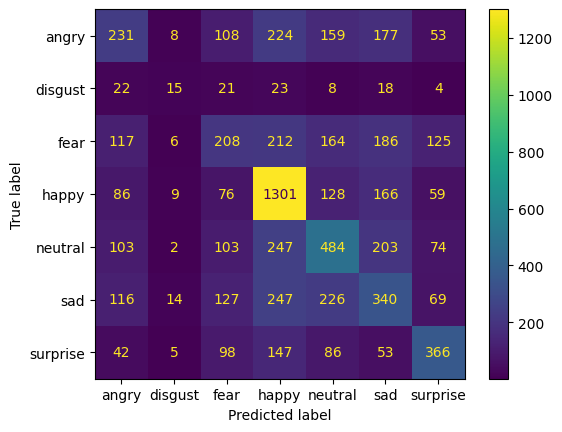

In [11]:

train_acc = log_reg.score(train_x_hog, train_y)
print("Training Accuracy: ", train_acc)

test_y_pred = log_reg.predict(test_x_hog)

test_acc = metrics.accuracy_score(test_y, test_y_pred)
test_prec = metrics.precision_score(test_y, test_y_pred, average='macro')
test_rec = metrics.recall_score(test_y, test_y_pred, average='macro')
test_f1 = metrics.f1_score(test_y, test_y_pred, average='macro')
test_confusion = metrics.confusion_matrix(test_y, test_y_pred)
print("Testing Accuracy: ", test_acc)
print("Testing Precision: ", test_prec)
print("Testing Recall: ", test_rec)
print("Testing F1: ", test_f1)
# print("Testing Confusion Matrix: ", test_confusion)

disp = metrics.ConfusionMatrixDisplay(test_confusion, display_labels=folders)
disp.plot()